In [1]:
from PIL import Image
from pix2tex.cli import LatexOCR
import pytesseract
import easyocr
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from collections import deque

In [2]:
def contour(image_path, tres=(235, 300), show=False):
    img = cv2.imread(image_path,  cv2.IMREAD_GRAYSCALE)
    img = cv2.Canny(img, threshold1=tres[0], threshold2=tres[1])
    
    if show is True:
        plt.imshow(img, cmap='gray')
    
    return img

In [3]:
def add_precision(vector, precision=1):
    if (precision == 0):
        return vector
    
    i = 0
    fin = len(vector)
    
    while True:
        if (vector[i] != 0):
            if ((i != 0) and (vector[i - 1] == 0)):
                for j in range(max(0, i - precision), i):
                    vector[j] = vector[i]
            if ((i != len(vector) - 1) and (vector[i + 1] == 0)):
                for j in range(i, min(len(vector), i + precision + 1)):
                    vector[j] = vector[i]
                i = min(len(vector), i + precision + 1) - 1
                
                
        i += 1
        if i >= len(vector) - 1:
            break

    return vector

In [4]:
def blur(img, precision=1, axis='x', show=False):
    
    t_img = img.copy()
    
    if axis != 'x':
        t_img = t_img.T
        
    for row in t_img:
        add_precision(row, precision)
    
    if axis != 'x':
        t_img = t_img.T
    
    if show is True:
        plt.imshow(t_img, cmap='gray')

    return t_img

Тестим код

In [5]:
#img закинул в ветку, чекайте
img = 'test.jpg'
image = cv2.imread(img,  cv2.IMREAD_GRAYSCALE)

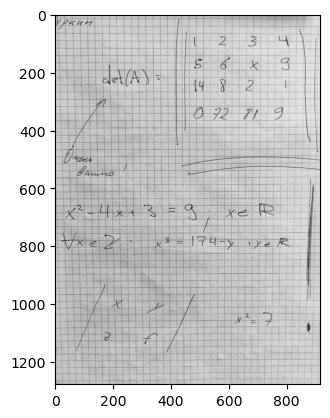

In [6]:
plt.imshow(image, cmap='gray')

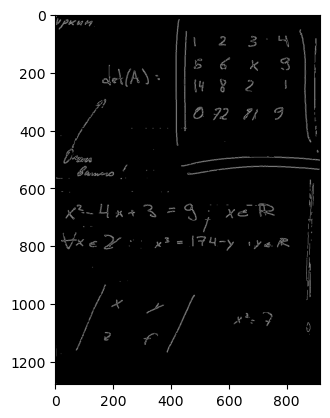

In [7]:
cont_img = contour(img, tres=(375, 451), show=True)

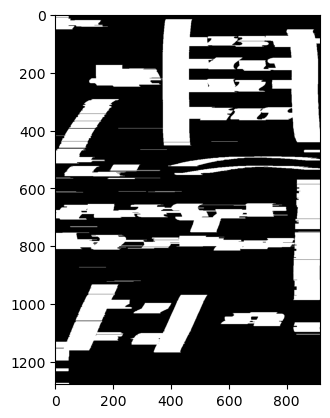

In [8]:
blurred = blur(cont_img, precision=45, axis='x', show=True)

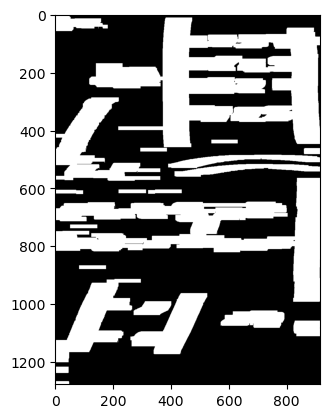

In [9]:
blurred = blur(blurred, precision=6, axis='y', show=True)

Конец тестирования

In [10]:
def BFS_segment(blurred, been, coords, show=False):
    
    segment = np.zeros_like(blurred)
    segment[coords[0]][coords[1]] = 1
    
    q_x = deque()
    q_x.append(coords[1])
    
    q_y = deque()
    q_y.append(coords[0])
    
    while q_x:
        i = q_y.popleft()
        j = q_x.popleft()
        
        if (j - 1 >= 0) and (been[i][j - 1] == 0) and (blurred[i][j - 1] == 1):
            q_x.append(j - 1)
            q_y.append(i)

            been[i][j - 1] = 1
            segment[i][j - 1] = 1
        
        if (i - 1 >= 0) and (been[i - 1][j] == 0) and (blurred[i - 1][j] == 1):
            q_x.append(j)
            q_y.append(i - 1)

            been[i - 1][j] = 1
            segment[i - 1][j] = 1
        
        if (j + 1 < len(blurred[0])) and (been[i][j + 1] == 0) and (blurred[i][j + 1] == 1):
            q_x.append(j + 1)
            q_y.append(i)

            been[i][j + 1] = 1
            segment[i][j + 1] = 1
        
        if (i + 1 < len(blurred)) and (been[i + 1][j] == 0) and (blurred[i + 1][j] == 1):
            q_x.append(j)
            q_y.append(i + 1)

            been[i + 1][j] = 1
            segment[i + 1][j] = 1
        
    if show is True:
        plt.imshow(segment, cmap='gray')
        
    return segment

In [11]:
def segmentation_BFS(blurred):
    been = np.zeros_like(blurred)
    blurred[blurred != 0] = 1
    segments = []
    while not np.array_equal(been, blurred):
        for i in range(len(blurred)):
            for j in range(len(blurred[i])):
                if (blurred[i][j] != 0) and (been[i][j] == 0):
                    been[i][j] = 1
                    segment = BFS_segment(blurred, been, coords=(i, j), show=False)
                    segments.append(segment)
    return segments

In [22]:
segments = segmentation_BFS(blurred)

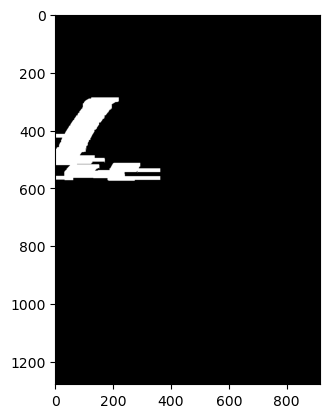

In [23]:
plt.imshow(segments[2], cmap='gray')

In [24]:
def show_part_of_image(segment, image):
    mask = segment.copy()
    mask[mask != 0] = 1
    mask = mask.astype(bool)
    
    iz = np.where(mask.astype(bool), image, 0)
    
    plt.imshow(iz, cmap='gray')
    
    return None

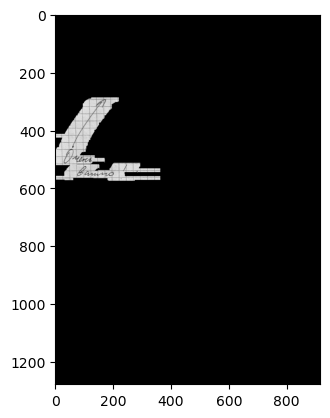

In [25]:
show_part_of_image(segments[2], image)

In [30]:
def put_projection_borders(segment, show=False):
    
    t_segment = segment.copy()
    
    x_proj = segment.any(axis=0)
    y_proj = segment.any(axis=1)
    
    
    def find_first(proj):
        for i in range(len(proj)):
            if proj[i]!=0:
                return i
    
    def find_last(proj):
        for i in range(len(proj) - 1, 0, -1):
            if proj[i]!=0:
                return i
    
    y_first = find_first(y_proj)
    y_last = find_last(y_proj)
    x_first = find_first(x_proj)
    x_last = find_last(x_proj) 
    
    t_segment[y_first:y_first+1, x_first:x_last] = 255
    t_segment[y_last-1:y_last, x_first:x_last] = 255
    t_segment[y_first:y_last, x_first+1] = 255
    t_segment[y_first:y_last, x_last-1:x_last] = 255
    
    t_segment[t_segment!=0] = 255
    
    if show is True:
        plt.imshow(t_segment, cmap='gray')
        
    return t_segment

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

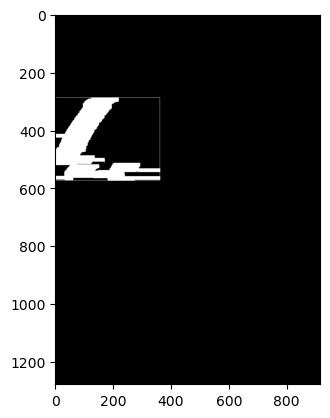

In [31]:
put_projection_borders(segments[2], show=True)

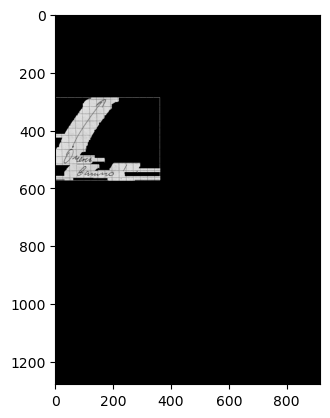

In [32]:
show_part_of_image(put_projection_borders(segments[2], show=True), image)

In [35]:
def cut_projection(segment, show=False):
    x_proj = segment.any(axis=0)
    y_proj = segment.any(axis=1)
    
    
    def find_first(proj):
        for i in range(len(proj)):
            if proj[i]!=0:
                return i
    
    def find_last(proj):
        for i in range(len(proj) - 1, 0, -1):
            if proj[i]!=0:
                return i
    
    y_first = find_first(y_proj)
    y_last = find_last(y_proj)
    x_first = find_first(x_proj)
    x_last = find_last(x_proj) 
    
    cut_segment = segment.copy()[y_first:y_last, x_first:x_last]
    
    cut_segment[cut_segment!=0] = 255
    
    if show is True:
        plt.imshow(cut_segment, cmap='gray')
        
    return cut_segment

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

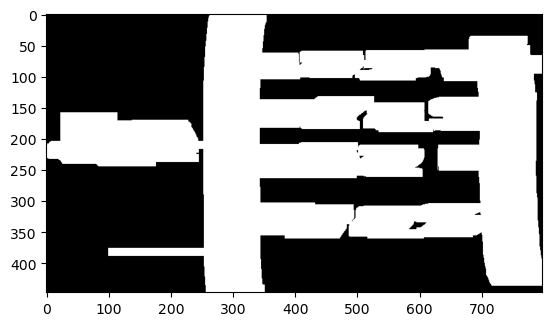

In [38]:
cut_projection(segments[1], show=True)